In [1]:
#Extracting file

import os
import zipfile

with zipfile.ZipFile('Alzheimer.zip', 'r') as zip_file:
    zip_file.extractall("./")

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
path_train = "/content/Alzheimer_s Dataset/train"
path_test = "/content/Alzheimer_s Dataset/test"

train_rescale = ImageDataGenerator(rescale=1./255)
test_rescale = ImageDataGenerator(rescale=1./255)

train_data = train_rescale.flow_from_directory(
    path_train,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)


test_data = test_rescale.flow_from_directory(
    path_test,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
#VGG-16 Model

vgg16_model_base = VGG16(weights=None, include_top=False, input_shape=(224, 224, 1))

for layer in vgg16_model_base.layers:
    layer.trainable = False

x = Flatten()(vgg16_model_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Optional: Add dropout for regularization
x = Dense(4, activation='softmax')(x)  # Assuming 4 classes

# Define the new model
vgg16_model = Model(inputs=vgg16_model_base.input, outputs=x)

vgg16_model.compile(optimizer=Adam(learning_rate=1e-4),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

vgg16_model.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

vgg_history = vgg16_model.fit(
        train_data,
        validation_data=test_data,
        epochs=10  # You can adjust the number of epochs
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 233ms/step - accuracy: 0.5045 - loss: 1.3184 - val_accuracy: 0.5004 - val_loss: 1.1518
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.4948 - loss: 1.1377 - val_accuracy: 0.5004 - val_loss: 1.0760
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.4949 - loss: 1.0759 - val_accuracy: 0.5004 - val_loss: 1.0528
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.4892 - loss: 1.0698 - val_accuracy: 0.5004 - val_loss: 1.0421
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.5075 - loss: 1.0451 - val_accuracy: 0.5004 - val_loss: 1.0363
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.5055 - loss: 1.0321 - val_accuracy: 0.5004 - val_loss: 1.0330
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.4988 - loss: 1.0427 - val_accuracy: 0.5004 - val_loss: 1.0310
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.5080 - loss: 1

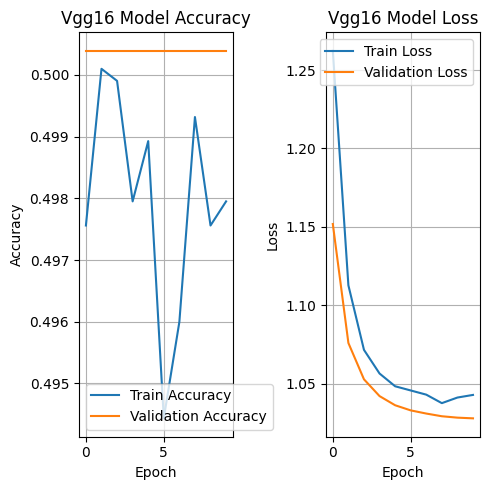

In [5]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(5, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Vgg16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('Vgg16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
test_loss, test_acc = vgg16_model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.5037 - loss: 1.0174
Test Loss: 1.0279583930969238
Test Accuracy: 0.5003909468650818


In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes on the test set
predictions = vgg16_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys())
print(class_report)

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step
[[  0   0 179   0]
 [  0   0  12   0]
 [  0   0 640   0]
 [  0   0 448   0]]
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      1.00      0.67       640
VeryMildDemented       0.00      0.00      0.00       448

        accuracy                           0.50      1279
       macro avg       0.13      0.25      0.17      1279
    weighted avg       0.25      0.50      0.33      1279

